# Import

In [ ]:
%matplotlib inline
from glob import glob
import cv2
import PIL
import math
import tqdm
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops

## Imbalance imports

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTEN
from sklearn.dummy import DummyClassifier

## Decomposition imports

In [ ]:
from sklearn.decomposition import PCA,FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

## Ensemble Imports

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Evaluation Metrics Imports

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_absolute_error, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Amrita/Semester 6/semester_projects/Machine Learning/Dataset/

In [ ]:
%ls

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [200, 200] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'COVID'
noncovid_path = 'non-COVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

In [ ]:
#lables generation
covid_labels = []
noncovid_labels = []
for i in range(len(covid_files)):
  covid_labels.append("covid")
for i in range(len(covid_files)):
  noncovid_labels.append("noncovid")

In [ ]:
files = covid_files + noncovid_files
lables = covid_labels + noncovid_labels
df = pd.DataFrame(list(zip(files, lables)),columns =['Files', 'Lables'])
df = df.sample(frac=1, random_state=42) #shuffle dataset

HSV Extraction

In [ ]:
# H = []
# S = []
# V = []
# label = []
# featLength = 2+5+2
# trainFeats = np.zeros((len(df),featLength)) #Feature vector of each image is of size 1x1030
# #for index in tqdm.tqdm_notebook(range(len(df))):
# img = PIL.Image.open(df["Files"][1]) #One image at a time
# img = img.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
# h,s,v = img.convert("HSV").split();
# print(type(h))
    


In [ ]:
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(df),featLength)) #Feature vector of each image is of size 1x1030
for index in tqdm.tqdm_notebook(range(len(df))):
    img = PIL.Image.open(df["Files"][index]) #One image at a time
    img = img.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
    img_gray = img.convert('L') #Converting to grayscale
    img_gray = PIL.ImageOps.equalize(img_gray, mask = None)
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[index,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(df["Lables"][index])
trainLabel = np.array(label) #Conversion from list to array

In [ ]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(2481,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(2481,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows

In [ ]:
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

In [ ]:
with open("trainFeatsNew.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabelNew.pckl", "wb") as f:
    pickle.dump(trainLabel, f)

In [ ]:

    
# Saving normalized testing data and labels
with open("testFeatsNew.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabelNew.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

In [ ]:
X = pd.read_pickle('https://github.com/SangeerthanaBalasubramaniam/COVID-19-Diagnosis/blob/main/trainFeatsNew.pckl?raw=true')
Y = pd.read_pickle('https://github.com/SangeerthanaBalasubramaniam/COVID-19-Diagnosis/blob/main/covidLable.pckl?raw=true')
X = pd.DataFrame(X,columns=['lbp_energy','lbp_entropy','glcm_contrast','glcm_dissimilarity','glcm_homogeniety','glcm_energy','glcm_correlation','gabor_energy','gabor_entropy'])
Y = pd.DataFrame(Y,columns=['labels'])

In [ ]:
label_encoder = LabelEncoder()
Y['labels'] = label_encoder.fit_transform(Y["labels"])

In [ ]:
X = X.sample(frac=1,random_state=42)
Y = Y.sample(frac=1,random_state=42)

In [ ]:
X = StandardScaler().fit_transform(X)

#Dataset Preprocessing

In [ ]:
Xdf = pd.read_pickle('https://github.com/SangeerthanaBalasubramaniam/COVID-19-Diagnosis/blob/main/trainFeatsNew.pckl?raw=true')
Ydf = pd.read_pickle('https://github.com/SangeerthanaBalasubramaniam/COVID-19-Diagnosis/blob/main/covidLable.pckl?raw=true')
Xdf = pd.DataFrame(Xdf,columns=['lbp_energy','lbp_entropy','glcm_contrast','glcm_dissimilarity','glcm_homogeniety','glcm_energy','glcm_correlation','gabor_energy','gabor_entropy'])
Ydf = pd.DataFrame(Ydf,columns=['labels'])
label_encoder = LabelEncoder()
Ydf['labels'] = label_encoder.fit_transform(Ydf["labels"]) #label encoding labels from categorical to 1 and 0
X = Xdf.sample(frac=1,random_state=42) #shuffling dataset
Y = Ydf.sample(frac=1,random_state=42) #shuffling dataset
Y = Y.values.reshape(-1,1)
X = StandardScaler().fit_transform(X) #Normalizing

## Data Imbalance

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f70f33390>]],
      dtype=object)

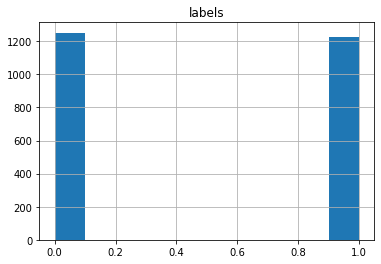

In [ ]:
Ydf.hist()

0-covid<br>
1-non-covid

In [ ]:
Ydf.value_counts()

labels
0         1252
1         1229
dtype: int64

In [ ]:
def ViewCounter():
  target = Ydf.values[:,-1]
  counter = Counter(target)
  for k,v in counter.items():
	  per = v / len(target) * 100
	  print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

In [ ]:
ViewCounter()

Class=0, Count=1252, Percentage=50.464%
Class=1, Count=1229, Percentage=49.536%


The dataset is imbalanced slightly and biased towards covid

### Over Sampling

In [ ]:
oversample = SMOTEN(random_state=0)
X,Y = oversample.fit_resample(X,Y)

In [ ]:
unique, counts = np.unique(Y, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1252],
       [   1, 1252]])

# Feature Engineering

## Normalization - Already done during extraction<br>
## One-hot encoding- neednot be done as they data are not categgorical<br>
## Imputation - need not be none as there are no null values<br>
## Feature Split - none of the features can be split further

## Outlier Removal

In [ ]:
print(Xdf.shape)
total = Xdf
total["labels"] = Ydf["labels"]
total
def removeOutlier():
  q1 = total['glcm_contrast'].quantile(0.25)
  print(q1)
  q3 = total['glcm_contrast'].quantile(0.75)
  print(q3)
  iqr = q3-q1
  print(iqr)
  upper = q3+1.5*iqr
  print(upper)
  lower = q1-1.5*iqr
  print(lower)
  df1 = total['glcm_contrast']
  n1 = np.where(df1>=upper)
  n2 = np.where(df1<=lower)
  total.drop(n1[0], inplace = True)
  total.drop(n2[0], inplace = True)
removeOutlier()
total.shape

(2481, 9)
0.11465121171207829
0.32803386507236476
0.21338265336028647
0.6481078451127944
-0.2054227683283514


(2448, 10)

In [ ]:
Xdf = total.iloc[:,0:-1]
Ydf = total.iloc[:,-1]
Y = total["labels"].values
X = total.drop("labels",axis=1).values

#Feature Decomposition

Dropped gabore filter and lbp energy due to their high correlation with gabore_entropy and lbp_energy

In [ ]:
#X = X.drop('gabor_energy', axis = 1)
#X = X.drop('lbp_entropy', axis = 1)

## Function for Testing Random Forest

In [ ]:
def RandomForestTest(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
    predictionforest = trainedforest.predict(X_Test)
    print(confusion_matrix(Y_Test,predictionforest))
    print(classification_report(Y_Test,predictionforest))

## PCA

In [ ]:
def Pca(n):
  pca = PCA(n_components=n)
  x = pca.fit_transform(X)
  return x

In [ ]:
X_pca = Pca(5)
RandomForestTest(X_pca,Y)

[[327  49]
 [ 64 295]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       376
           1       0.86      0.82      0.84       359

    accuracy                           0.85       735
   macro avg       0.85      0.85      0.85       735
weighted avg       0.85      0.85      0.85       735



## Fast ICA

In [ ]:
def Ica(n):
  ica = FastICA(n_components=n)
  x = ica.fit_transform(X)
  return x

In [ ]:
X_Ica = Ica(5)
RandomForestTest(X_Ica,Y)

[[337  39]
 [ 53 306]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       376
           1       0.89      0.85      0.87       359

    accuracy                           0.87       735
   macro avg       0.88      0.87      0.87       735
weighted avg       0.88      0.87      0.87       735



## LDA

In [ ]:
def Lda(n):
  lda = LinearDiscriminantAnalysis(n_components=n)

  # run an LDA and use it to transform the features
  x = lda.fit(X, Y).transform(X)
  print('Original number of features:', X.shape[1])
  print('Reduced number of features:', x.shape[1])
  return x

In [ ]:
X_lda = Lda(1)
RandomForestTest(X_lda,Y)

Original number of features: 9
Reduced number of features: 1
[[228 148]
 [157 202]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       376
           1       0.58      0.56      0.57       359

    accuracy                           0.59       735
   macro avg       0.58      0.58      0.58       735
weighted avg       0.58      0.59      0.58       735



##LLE

In [ ]:
def Lle(n):
  embedding = LocallyLinearEmbedding(n_components=3)
  x = embedding.fit_transform(X)
  return x

In [ ]:
X_lle = Lle(5)
RandomForestTest(X_lle,Y)

[[270 106]
 [101 258]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       376
           1       0.71      0.72      0.71       359

    accuracy                           0.72       735
   macro avg       0.72      0.72      0.72       735
weighted avg       0.72      0.72      0.72       735



## t-SNE

In [ ]:
def Tsne(n,verbose,preplexity,n_iter):
  tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
  x = tsne.fit_transform(X)
  return x

In [ ]:
X_tsne = Tsne(5,1,40,3000)
RandomForestTest(X_lle,Y)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2448 samples in 0.008s...
[t-SNE] Computed neighbors for 2448 samples in 0.097s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 2448
[t-SNE] Computed conditional probabilities for sample 2000 / 2448
[t-SNE] Computed conditional probabilities for sample 2448 / 2448
[t-SNE] Mean sigma: 0.040742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.364292
[t-SNE] KL divergence after 300 iterations: 0.762938
[[274 102]
 [103 256]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       376
           1       0.72      0.71      0.71       359

    accuracy                           0.72       735
   macro avg       0.72      0.72      0.72       735
weighted avg       0.72      0.72      0.72       735



## Autoencoders

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

input_layer = Input(shape=(X.shape[1],))
encoded = Dense(9, activation='tanh')(input_layer)
decoded = Dense(X.shape[1], activation='softmax')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(X, X, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = 30,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
X_ae = encoder.predict(X)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [ ]:
RandomForestTest(X_ae,Y)

[[298  78]
 [ 69 290]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       376
           1       0.79      0.81      0.80       359

    accuracy                           0.80       735
   macro avg       0.80      0.80      0.80       735
weighted avg       0.80      0.80      0.80       735



# Comparison between models

## ID3 

In [ ]:
from sklearn import tree
def ID(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_Train, Y_Train)
    prediction = clf.predict(X_Test)
    print(confusion_matrix(Y_Test,prediction))
    print(classification_report(Y_Test,prediction))

In [ ]:
ID(X,Y)

[[304  72]
 [ 67 292]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       376
           1       0.80      0.81      0.81       359

    accuracy                           0.81       735
   macro avg       0.81      0.81      0.81       735
weighted avg       0.81      0.81      0.81       735



## SVM

In [ ]:
from sklearn import svm
def SVM(X, Y):    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    clf = svm.SVC()
    clf = clf.fit(X_Train, Y_Train)
    prediction = clf.predict(X_Test)
    print(confusion_matrix(Y_Test,prediction))
    print(classification_report(Y_Test,prediction))

In [ ]:
SVM(X,Y)

[[297  79]
 [ 84 275]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       376
           1       0.78      0.77      0.77       359

    accuracy                           0.78       735
   macro avg       0.78      0.78      0.78       735
weighted avg       0.78      0.78      0.78       735



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def Logistic(X,Y):
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
  model = LogisticRegression()
  model = model.fit(X_Train,Y_Train)
  prediction = model.predict(X_Test)
  print(confusion_matrix(Y_Test,prediction))
  print(classification_report(Y_Test,prediction))
Logistic(X,Y)

[[248 128]
 [140 219]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       376
           1       0.63      0.61      0.62       359

    accuracy                           0.64       735
   macro avg       0.64      0.63      0.63       735
weighted avg       0.64      0.64      0.64       735



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
def knn(X,Y):
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
  n = round(math.sqrt(X.size))
  classifier= KNeighborsClassifier(n_neighbors=n, metric='minkowski', p=2 )  
  classifier.fit(X_Train, Y_Train)
  prediction = classifier.predict(X_Test)
  print(confusion_matrix(Y_Test,prediction))
  print(classification_report(Y_Test,prediction))
knn(X,Y)

[[257 119]
 [108 251]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       376
           1       0.68      0.70      0.69       359

    accuracy                           0.69       735
   macro avg       0.69      0.69      0.69       735
weighted avg       0.69      0.69      0.69       735

